In [1]:
%pip install keras

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import spacy
import string
import regex as re
from unidecode import unidecode
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv("Twitter_Data.csv")
df2 = pd.read_csv("Reddit_Data.csv")
df2 = df2.rename(columns={'clean_comment': 'clean_text'})
df3 = pd.read_csv("twitter_training.csv", names=['id', 'product', 'category', 'clean_text'])
df3 = df3[['clean_text', 'category']]
df4 = pd.read_csv("train.csv", encoding='iso-8859-1')
df4 = df4.rename(columns={'text': 'clean_text', 'sentiment': 'category'})
df4 = df4[['clean_text', 'category']]

In [5]:
df2

,clean_text,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1
...,...,...
37244,jesus,0
37245,kya bhai pure saal chutiya banaya modi aur jab...,1
37246,downvote karna tha par upvote hogaya,0
37247,haha nice,1


In [6]:
df['category'] = df['category'].replace({-1: 0, 0: 1, 1: 2})
df2['category'] = df2['category'].replace({-1: 0, 0: 1, 1: 2})
df3['category'] = df3['category'].replace({"Negative": 0, "Neutral": 1, "Positive": 2})
df4['category'] = df4['category'].replace({"negative": 0, "neutral": 1, "positive": 2})

C:\Users\Victor\AppData\Local\Temp\ipykernel_19168\2629549137.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df4['category'] = df4['category'].replace({"negative": 0, "neutral": 1, "positive": 2})


In [7]:
df = pd.concat([df, df2, df3, df4], ignore_index=True)

In [8]:
df = df.drop_duplicates(subset=['clean_text'])

In [9]:
df = df.dropna(subset=['clean_text'])
df = df.dropna(subset=['category'])

In [10]:
df = df[df['category'] != 'Irrelevant']
df['category'] = df['category'].astype(int)

In [11]:
df

,clean_text,category
0,when modi promised “minimum government maximum...,0
1,talk all the nonsense and continue all the dra...,1
2,what did just say vote for modi welcome bjp t...,2
3,asking his supporters prefix chowkidar their n...,2
4,answer who among these the most powerful world...,2
...,...,...
302387,wish we could come see u on Denver husband l...,0
302388,I`ve wondered about rake to. The client has ...,0
302389,Yay good for both of you. Enjoy the break - y...,2
302390,But it was worth it ****.,2


In [12]:
def to_lower(text):
    return text.lower()

In [13]:
df['clean_text'] = df['clean_text'].apply(to_lower)

In [14]:
df

,clean_text,category
0,when modi promised “minimum government maximum...,0
1,talk all the nonsense and continue all the dra...,1
2,what did just say vote for modi welcome bjp t...,2
3,asking his supporters prefix chowkidar their n...,2
4,answer who among these the most powerful world...,2
...,...,...
302387,wish we could come see u on denver husband l...,0
302388,i`ve wondered about rake to. the client has ...,0
302389,yay good for both of you. enjoy the break - y...,2
302390,but it was worth it ****.,2


In [15]:
def remove_punctuation(text):
    punct = string.punctuation
    punct = punct.replace("'", "")
    translator = str.maketrans('', '', punct)
    return text.translate(translator)

In [16]:
df['clean_text'] = df['clean_text'].apply(remove_punctuation)

In [17]:
df

,clean_text,category
0,when modi promised “minimum government maximum...,0
1,talk all the nonsense and continue all the dra...,1
2,what did just say vote for modi welcome bjp t...,2
3,asking his supporters prefix chowkidar their n...,2
4,answer who among these the most powerful world...,2
...,...,...
302387,wish we could come see u on denver husband l...,0
302388,ive wondered about rake to the client has ma...,0
302389,yay good for both of you enjoy the break you...,2
302390,but it was worth it,2


In [18]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F300-\U0001F5FF"  # simbol and pictogramas
                               u"\U0001F680-\U0001F6FF"  # transport and ]simbol of map
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [19]:
df['clean_text'] = df['clean_text'].apply(remove_emojis)

In [20]:
df

,clean_text,category
0,when modi promised “minimum government maximum...,0
1,talk all the nonsense and continue all the dra...,1
2,what did just say vote for modi welcome bjp t...,2
3,asking his supporters prefix chowkidar their n...,2
4,answer who among these the most powerful world...,2
...,...,...
302387,wish we could come see u on denver husband l...,0
302388,ive wondered about rake to the client has ma...,0
302389,yay good for both of you enjoy the break you...,2
302390,but it was worth it,2


In [21]:
def remove_urls(text):
    http = r"http\S+|www\.\S+"
    pattern = re.compile(r"({})".format(http))
    return pattern.sub(r'', text)

In [22]:
df['clean_text'] = df['clean_text'].apply(remove_urls)

In [23]:
df

,clean_text,category
0,when modi promised “minimum government maximum...,0
1,talk all the nonsense and continue all the dra...,1
2,what did just say vote for modi welcome bjp t...,2
3,asking his supporters prefix chowkidar their n...,2
4,answer who among these the most powerful world...,2
...,...,...
302387,wish we could come see u on denver husband l...,0
302388,ive wondered about rake to the client has ma...,0
302389,yay good for both of you enjoy the break you...,2
302390,but it was worth it,2


In [24]:
def remove_accent(text):
    return unidecode(text)

In [25]:
df['clean_text'] = df['clean_text'].apply(remove_accent)

In [26]:
df

,clean_text,category
0,"when modi promised ""minimum government maximum...",0
1,talk all the nonsense and continue all the dra...,1
2,what did just say vote for modi welcome bjp t...,2
3,asking his supporters prefix chowkidar their n...,2
4,answer who among these the most powerful world...,2
...,...,...
302387,wish we could come see u on denver husband l...,0
302388,ive wondered about rake to the client has ma...,0
302389,yay good for both of you enjoy the break you...,2
302390,but it was worth it,2


In [27]:
def remove_numbers(texto):
    return re.sub(r'\d+', '', texto)

In [28]:
df['clean_text'] = df['clean_text'].apply(remove_numbers)

In [29]:
df

,clean_text,category
0,"when modi promised ""minimum government maximum...",0
1,talk all the nonsense and continue all the dra...,1
2,what did just say vote for modi welcome bjp t...,2
3,asking his supporters prefix chowkidar their n...,2
4,answer who among these the most powerful world...,2
...,...,...
302387,wish we could come see u on denver husband l...,0
302388,ive wondered about rake to the client has ma...,0
302389,yay good for both of you enjoy the break you...,2
302390,but it was worth it,2


In [30]:
def remove_broke_line(texto):
    return texto.replace('\n', ' ')

In [31]:
df['clean_text'] = df['clean_text'].apply(remove_broke_line)

In [32]:
df

,clean_text,category
0,"when modi promised ""minimum government maximum...",0
1,talk all the nonsense and continue all the dra...,1
2,what did just say vote for modi welcome bjp t...,2
3,asking his supporters prefix chowkidar their n...,2
4,answer who among these the most powerful world...,2
...,...,...
302387,wish we could come see u on denver husband l...,0
302388,ive wondered about rake to the client has ma...,0
302389,yay good for both of you enjoy the break you...,2
302390,but it was worth it,2


In [33]:
def strip_text(text):
    return text.strip()

In [34]:
df['clean_text'] = df['clean_text'].apply(strip_text)

In [35]:
df = df.dropna(subset=['clean_text'])

In [36]:
df

,clean_text,category
0,"when modi promised ""minimum government maximum...",0
1,talk all the nonsense and continue all the dra...,1
2,what did just say vote for modi welcome bjp t...,2
3,asking his supporters prefix chowkidar their n...,2
4,answer who among these the most powerful world...,2
...,...,...
302387,wish we could come see u on denver husband lo...,0
302388,ive wondered about rake to the client has mad...,0
302389,yay good for both of you enjoy the break you ...,2
302390,but it was worth it,2


In [37]:
def df_metadata(df):
    metadata = pd.DataFrame(df.dtypes, columns=['dtypes'])
    metadata = metadata.reset_index()
    metadata['Column'] = metadata['index']
    metadata = metadata[['Column', 'dtypes']]
    metadata['# Missing'] = df.isnull().sum().values    
    metadata['# Unique'] = df.nunique().values
    
    # Verificar se o DataFrame não está vazio
    if not df.empty:
        metadata['Example'] = df.iloc[0].values
    else:
        metadata['Example'] = None
    
    return metadata

# Aplicar a função ao DataFrame
df_metadata(df)

,Column,dtypes,# Missing,# Unique,Example
0,clean_text,object,0,278736,"when modi promised ""minimum government maximum..."
1,category,int32,0,3,0


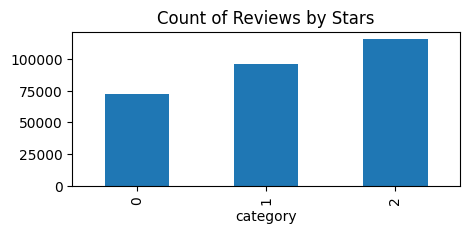

In [38]:
ax = df['category'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(5,2))

In [39]:
example = df['clean_text'].iloc[3]
print(example)

asking his supporters prefix chowkidar their names modi did great service now there confusion what read what not now crustal clear what will crass filthy nonsensical see how most abuses are coming from chowkidars


In [40]:
# Contar o número de cada categoria
counts = df['category'].value_counts()

# Mostrar os resultados
print("Número de ocorrências para cada categoria:")
print("Categoria 0:", counts.get(0, 0))
print("Categoria 1:", counts.get(1, 0))
print("Categoria 2:", counts.get(2, 0))

Número de ocorrências para cada categoria:
Categoria 0: 72691
Categoria 1: 96116
Categoria 2: 115631


In [87]:
# Contar o número mínimo de ocorrências entre todas as categorias
min_count = counts.min()

# Amostrar aleatoriamente o mesmo número de amostras de cada categoria
balanced_df = pd.concat([
    df[df['category'] == category].sample(min_count, replace=True, random_state=42)
    for category in counts.index
])

# Verificar o novo número de ocorrências para cada categoria
balanced_counts = balanced_df['category'].value_counts()

# Mostrar os resultados
print("Número de ocorrências para cada categoria após o balanceamento:")
for category, count in balanced_counts.items():
    print(f"Categoria {category}: {count}")

Número de ocorrências para cada categoria após o balanceamento:
Categoria 2: 72691
Categoria 1: 72691
Categoria 0: 72691


In [88]:
X = df['clean_text']
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inicializar o vetorizador
vectorizer = TfidfVectorizer(max_features=10000, strip_accents='unicode')

# Ajustar e transformar os dados de treinamento
X_train_vectors = vectorizer.fit_transform(X_train)
# Transformar os dados de teste
X_test_vectors = vectorizer.transform(X_test)

In [79]:
# from sklearn.utils.class_weight import compute_class_weight

# # Verificar os valores únicos em y_train
# unique_classes = np.unique(y_train)
# print("Classes únicas:", unique_classes)

# # Calcular o número de amostras em cada classe
# class_counts = np.bincount(y_train)

# # Calcular o total de amostras
# total_samples = np.sum(class_counts)

# # Calcular os pesos das classes manualmente
# class_weights = {cls: total_samples / (len(unique_classes) * count) for cls, count in enumerate(class_counts)}

# print("Pesos das classes:", class_weights)

Classes únicas: [0 1 2]
Pesos das classes: {0: 1.3029064174797307, 1: 0.9865768320283032, 2: 0.8204257344351663}


In [90]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input

# Inicializar o modelo
model = Sequential()

# Adicionar camadas densas
model.add(Input(shape=(X_train_vectors.shape[1],)))  # Utilizando Input(shape)
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Dropout para regularização

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

# Camada de saída
model.add(Dense(3, activation='softmax'))  # 3 classes: positivo, negativo, neutro
# model.add_weight(class_weights)


# Compilar o modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 642,243 (2.45 MB)

 Trainable params: 642,243 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
# Definir o EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1,restore_best_weights=True)

# Treinar o modelo com EarlyStopping e pesos das classes
history = model.fit(X_train_vectors, y_train, epochs=50, batch_size=32, 
                    validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 46s 7ms/step - accuracy: 0.6634 - loss: 0.7599 - val_accuracy: 0.8427 - val_loss: 0.4196
Epoch 2/50
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 46s 7ms/step - accuracy: 0.8351 - loss: 0.4554 - val_accuracy: 0.8610 - val_loss: 0.3811
Epoch 3/50
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - accuracy: 0.8636 - loss: 0.3885 - val_accuracy: 0.8688 - val_loss: 0.3629
Epoch 4/50
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - accuracy: 0.8753 - loss: 0.3564 - val_accuracy: 0.8748 - val_loss: 0.3548
Epoch 5/50
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step - accuracy: 0.8862 - loss: 0.3260 - val_accuracy: 0.8767 - val_loss: 0.3531
Epoch 6/50
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 76s 12ms/step - accuracy: 0.8927 - loss: 0.3097 - val_accuracy: 0.8775 - val_loss: 0.3541
Epoch 7/50
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 66s 10ms/step - accuracy: 0.8990 - loss: 0.2936 - val_accuracy: 0.8769 - val_loss: 0.3634
Epoch 8/50
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 69s 11ms/step - accuracy: 0.9026 - loss

In [92]:
# Avaliar o modelo no conjunto de teste
loss, accuracy = model.evaluate(X_test_vectors, y_test)

# Imprimir a acurácia
print("Accuracy:", accuracy)

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8706 - loss: 0.3683
Accuracy: 0.8725214600563049


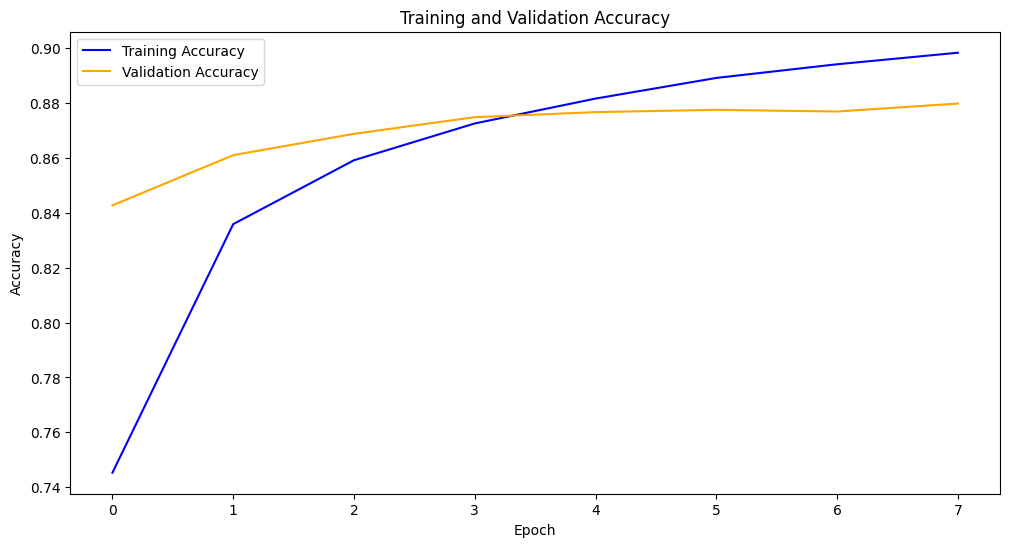

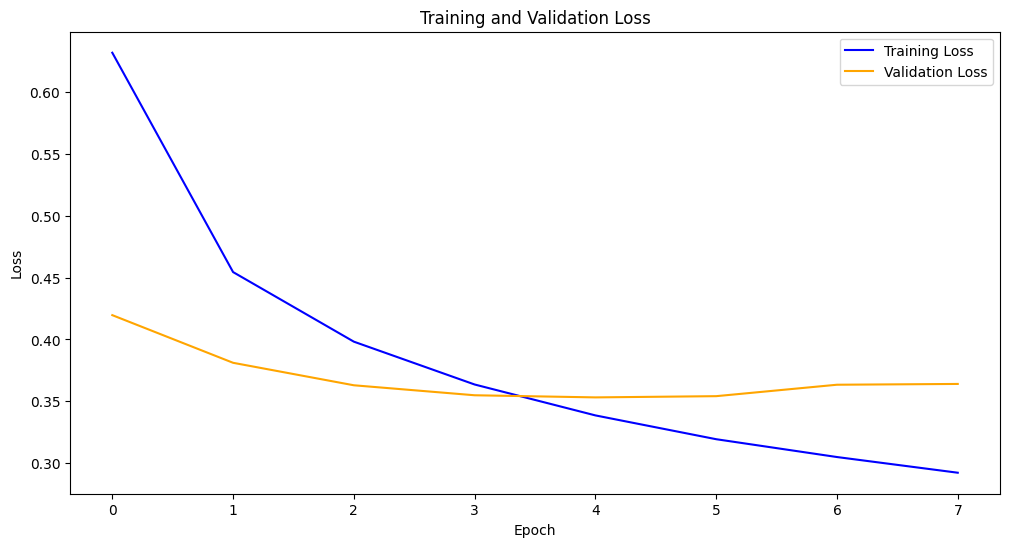

In [93]:
# Extrair acurácia e perda do histórico
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotar acurácia
plt.figure(figsize=(12, 6))
plt.plot(accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotar perda
plt.figure(figsize=(12, 6))
plt.plot(loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


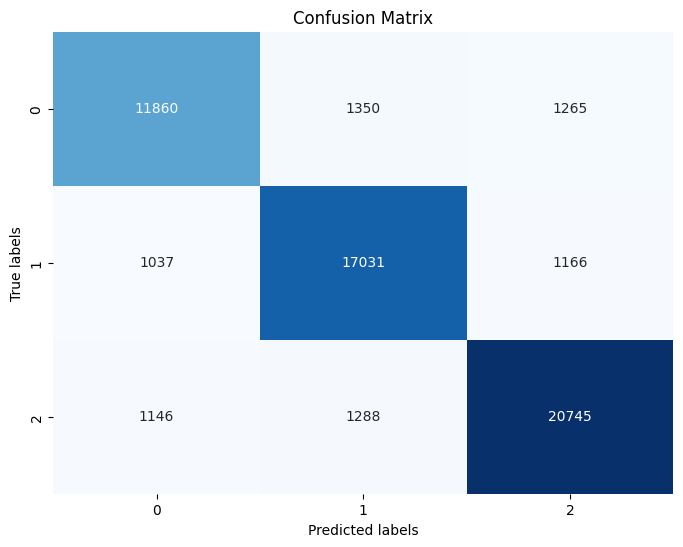

In [94]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

classes = np.unique(y_test)

# Fazer previsões nos dados de teste
y_pred = model.predict(X_test_vectors)
# Obter as classes previstas convertendo as probabilidades em rótulos
y_pred_labels = np.argmax(y_pred, axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Visualizar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()